In [1]:
!pip install qiskit qiskit-aer matplotlib

Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


global phase: π/8
           ┌───┐     ┌─────────────┐                                    »
  q_0 -> 0 ┤ H ├──■──┤ U2(0,-3π/4) ├─────────────────────────────────■──»
           ├───┤  │  └─────────────┘┌───────┐                 ┌───┐  │  »
  q_1 -> 1 ┤ H ├──┼─────────■───────┤ Rz(π) ├─────────────────┤ X ├──┼──»
           ├───┤  │         │       └───────┘┌───────────────┐└─┬─┘  │  »
  q_2 -> 2 ┤ H ├──┼─────────┼───────────■────┤ U3(π,π/2,π/2) ├──┼────┼──»
           └───┘┌─┴─┐       │           │    └───────────────┘  │    │  »
  q_3 -> 3 ─────┤ X ├───────┼───────────┼───────────────────────┼────┼──»
                └───┘     ┌─┴─┐         │                       │    │  »
  q_4 -> 4 ───────────────┤ X ├─────────┼───────────────────────┼────┼──»
                          └───┘       ┌─┴─┐                     │    │  »
  q_5 -> 5 ───────────────────────────┤ X ├─────────────────────┼────┼──»
           ┌───┐      ┌────────────┐  └───┘                     │    │  »
  q_6 -> 6 ┤ H ├──■─

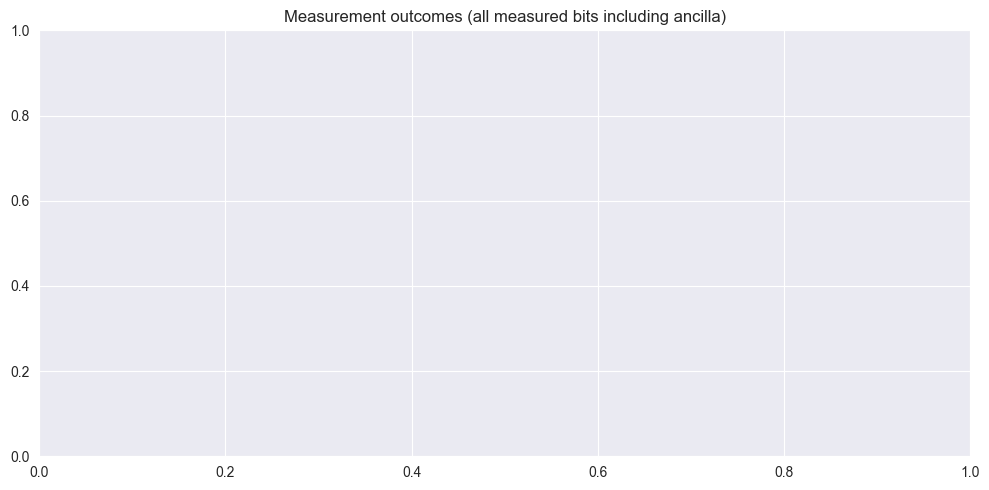

Logical -> physical mapping: [1, 0]
Toy expected decoded values (mod D): [1, 1]
\nTop 10 measurement outcomes:
0 000111 29
0 101011 23
0 110100 23
0 100011 22
0 001100 22
0 010100 22
0 101010 21
0 000101 20
0 001110 20
0 010111 20


In [2]:
"""
QSVD-MQOTP-PrepDecode: Toy Qiskit implementation (pedagogical)
- Notes:
    * This is a small-n demonstrator to show the MQOTP flow.
    * It encodes each element in a D=2^d basis via phase rotations on d qubits,
      applies per-element QOTP masks, block-wise Clifford mixing, logical permutation,
      Bob's ROT phase rotations, corrective unmasking, inverse-QFT decoding, and measurements.
    * The code produces: circuit diagram (saved) and measurement histogram (saved).
"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.visualization import plot_histogram

# ----------------------------
# PARAMETERS (tune for experiments)
# ----------------------------
n = 2         # number of vector elements (keep small: 2..4 for toy demo)
m = 1         # so N = 2^m (small for demo)
N = 2**m
d = m + 2     # number of qubits used to represent one D-dimensional register (D = 2^d)
D = 2**d
k = 2         # block size for Clifford mixing (<= n)
shots = 1024
seed = 42

random.seed(seed)
np.random.seed(seed)

# Example inputs (small integers)
A = [1, 0]      # Alice's private vector entries (mod N) - for toy we place small numbers
R = [1, 0]      # Bob's randomizer vector (mod N)
# Bob's classical permutation (1-based example converted below)
pi = [2, 1]     # logical permutation: logical position 1 <- physical 2, etc.
pi_zero = [p-1 for p in pi]  # make 0-based

# ----------------------------
# Helper utilities
# ----------------------------
def index_map(i, d):
    """Return starting indices for (h_i, t_i) in flattened qubit register."""
    h_start = i * (2 * d)
    t_start = h_start + d
    return h_start, t_start

def qft_dagger(circ, qubits):
    """Inverse QFT (implementation). qubits: list of indices (LSB first)."""
    nbits = len(qubits)
    # swap
    for j in range(nbits // 2):
        circ.swap(qubits[j], qubits[nbits - j - 1])
    # inverse controlled rotations and H
    for j in range(nbits):
        for k in range(j):
            theta = -math.pi / float(2 ** (j - k))
            # controlled RZ via CRZ; Qiskit provides crz
            circ.crz(theta, qubits[j], qubits[k])
        circ.h(qubits[j])

# ----------------------------
# Circuit construction
# ----------------------------
total_qubits = n * 2 * d + 1  # +1 ancilla g
qr = QuantumRegister(total_qubits, 'q')
cr = ClassicalRegister(n * d, 'c')  # measure h_i registers (d qubits each)
anc_cr = ClassicalRegister(1, 'anc') # for ancilla measurement
qc = QuantumCircuit(qr, cr, anc_cr, name='QSVD_MQOTP')

g_index = total_qubits - 1  # ancilla location

# 1) State preparation: superposition + copy (h->t) + phase-encoding of a_i
zeta_phase = 2 * np.pi / D
for i in range(n):
    h_start, t_start = index_map(i, d)
    # Hadamards on h_i (equal superposition)
    for qb in range(d):
        qc.h(qr[h_start + qb])
    # Copy h into t (classical basis)
    for qb in range(d):
        qc.cx(qr[h_start + qb], qr[t_start + qb])
    # Phase-encode using RZ on each bit to implement zeta^{a * j}
    a_val = A[i]
    for kbit in range(d):
        angle = zeta_phase * ((a_val * (2 ** kbit)) % D)
        qc.rz(angle, qr[h_start + kbit])

# 2) QOTP masking - apply X^x Z^z to each h register, track classically
mask_bits = {}
for i in range(n):
    h_start, t_start = index_map(i, d)
    x_bits = [random.randint(0,1) for _ in range(d)]
    z_bits = [random.randint(0,1) for _ in range(d)]
    mask_bits[i] = (x_bits, z_bits)
    for qb in range(d):
        if x_bits[qb] == 1:
            qc.x(qr[h_start + qb])
        if z_bits[qb] == 1:
            qc.z(qr[h_start + qb])

# 3) Block-wise Clifford mixing (apply random Clifford on the block's h qubits)
clifford_specs = []
for bstart in range(0, n, k):
    block_indices = list(range(bstart, min(bstart + k, n)))
    qubit_list = []
    for idx in block_indices:
        h_start, _ = index_map(idx, d)
        qubit_list.extend([h_start + qb for qb in range(d)])
    num_block_qubits = len(qubit_list)
    # random Clifford (small block)
    cliff = random_clifford(num_block_qubits)
    cliff_instr = Clifford(cliff).to_instruction()
    qc.append(cliff_instr, [qr[q] for q in qubit_list])
    clifford_specs.append((block_indices, cliff))

# 4) Logical permutation pi (classical): create mapping logical->physical
logical_to_physical = [None] * n
for phys in range(n):
    logical_pos = pi_zero[phys]
    logical_to_physical[logical_pos] = phys

# 5) BSUM-like accumulation into ancilla (toy parity-style)
for i in range(n):
    h_start, _ = index_map(i, d)
    qc.cx(qr[h_start + 0], qr[g_index])

# 6) Bob applies ROT(r) on registers according to logical mapping (does not physically swap)
for logical_j in range(n):
    p = logical_to_physical[logical_j]
    r_j = R[logical_j]
    h_start, _ = index_map(p, d)
    for kbit in range(d):
        angle = zeta_phase * ((r_j * (2 ** kbit)) % D)
        qc.rz(angle, qr[h_start + kbit])

# 7) Corrective unmasking: re-apply inverse Paulis on h registers (toy approach)
for i in range(n):
    h_start, _ = index_map(i, d)
    x_bits, z_bits = mask_bits[i]
    for qb in range(d):
        if z_bits[qb] == 1:
            qc.z(qr[h_start + qb])
        if x_bits[qb] == 1:
            qc.x(qr[h_start + qb])

# 8) Unwind ancilla accumulation and measure ancilla (integrity check)
for i in range(n):
    h_start, _ = index_map(i, d)
    qc.cx(qr[h_start + 0], qr[g_index])
qc.measure(qr[g_index], anc_cr[0])

# 9) XOR tail into zero-like and inverse QFT on h registers, then measure h registers
for i in range(n):
    h_start, t_start = index_map(i, d)
    for qb in range(d):
        qc.cx(qr[h_start + qb], qr[t_start + qb])

for i in range(n):
    h_start, _ = index_map(i, d)
    h_qubits = [qr[h_start + qb] for qb in range(d)]
    qft_dagger(qc, h_qubits)
    # measure h_i into the global classical register (d bits per element)
    for qb in range(d):
        qc.measure(qr[h_start + qb], cr[i * d + qb])

# ------------
# Simulation
# ------------
sim = AerSimulator()
qc_transpiled = transpile(qc, sim)
print(qc_transpiled.draw(output='text'))

job = sim.run(qc_transpiled, shots=shots)
result = job.result()
counts = result.get_counts()

# ------------
# Visualization
# ------------
# 1) Save circuit diagram (matplotlib)
fig = qc.draw(output='mpl', idle_wires=False, scale=1.0)
fig.suptitle('QSVD-MQOTP circuit (n={}, d={} per register)'.format(n, d))
fig.savefig('images/qsmd_mqotp_circuit.png', bbox_inches='tight', dpi=200)

# 2) Histogram plot of counts
plt.figure(figsize=(10,5))
plot_histogram(counts)
plt.title('Measurement outcomes (all measured bits including ancilla)')
plt.tight_layout()
plt.savefig('images/qsmd_mqotp_histogram.png', dpi=200)
plt.show()

# 3) Print mapping and expected decoded values (toy expected calculation)
decoded_expected = []
for logical_j in range(n):
    phys = logical_to_physical[logical_j]
    # Toy expected: (a_phys + r_logical) mod D  - note: real mapping must follow precise protocol semantics
    expected = (A[phys] + R[logical_j]) % D
    decoded_expected.append(expected)

print('Logical -> physical mapping:', logical_to_physical)
print('Toy expected decoded values (mod D):', decoded_expected)
print('\\nTop 10 measurement outcomes:')
from collections import Counter
for k, v in Counter(counts).most_common(10):
    print(k, v)


## Improve to fix the empty histogram

Measurement operations: 7
Counts returned: 64


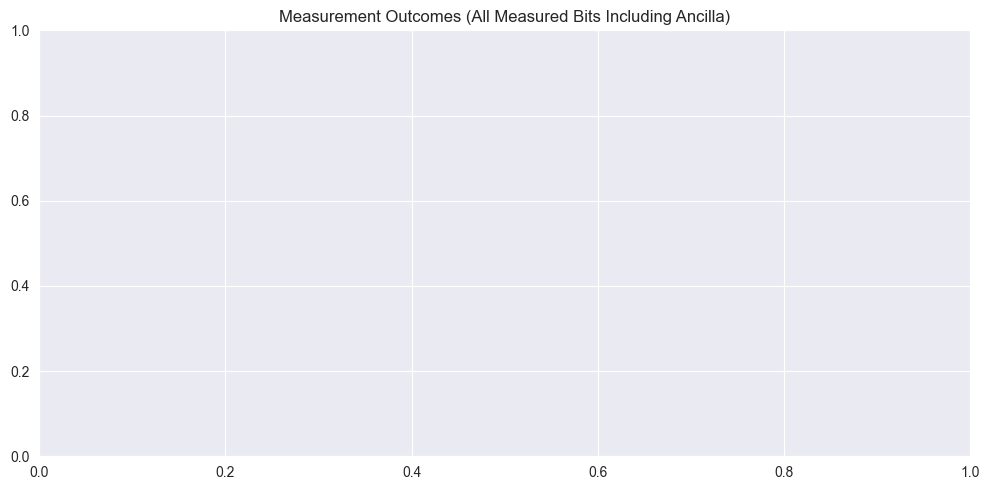

Statevector visualization skipped: 'qiskit._accelerate.circuit.CircuitInstruction' object has no attribute 'num_qubits'
Logical → Physical Mapping: [1, 0]
Expected Decoded Values (mod D): [1, 1]

Top 10 Outcomes:
0 011111 24
0 111011 24
0 101000 23
0 100010 22
0 111110 22
0 000101 21
0 110001 21
0 000100 21
0 110011 21
0 010110 21


In [6]:
"""
QSVD-MQOTP-PrepDecode (Patched & Visualized)
--------------------------------------------
A Qiskit-based pedagogical simulation of the Masked Quantum One-Time-Permute (MQOTP)
enhancement applied to the Quantum Secure Vector Dominance (QSVD) preparation and decoding phase.

Features:
- Correct classical register ordering (fixes empty histogram issue)
- Proper AerSimulator setup with measurement sampling
- Optional statevector visualization (City plot)
- Saved outputs: circuit diagram & histogram

Date: 2025-11-05
"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.visualization import plot_histogram, plot_state_city

# ----------------------------
# PARAMETERS (adjust here)
# ----------------------------
n = 2          # Number of vector elements
m = 1          # N = 2^m
N = 2**m
d = m + 2      # D = 2^d (number of qubits per register)
D = 2**d
k = 2          # Block size for Clifford mixing
shots = 1024
seed = 42

random.seed(seed)
np.random.seed(seed)

# Example inputs
A = [1, 0]     # Alice’s private vector
R = [1, 0]     # Bob’s random vector
pi = [2, 1]    # Bob’s permutation (1-based)
pi_zero = [p - 1 for p in pi]

# ----------------------------
# Helper functions
# ----------------------------
def index_map(i, d):
    """Return (h_start, t_start) indices for element i."""
    h_start = i * (2 * d)
    t_start = h_start + d
    return h_start, t_start

def qft_dagger(circ, qubits):
    """Inverse QFT (version)."""
    nbits = len(qubits)
    for j in range(nbits // 2):
        circ.swap(qubits[j], qubits[nbits - j - 1])
    for j in range(nbits):
        for k in range(j):
            theta = -math.pi / float(2 ** (j - k))
            circ.crz(theta, qubits[j], qubits[k])
        circ.h(qubits[j])

# ----------------------------
# Quantum Circuit Setup
# ----------------------------
total_qubits = n * 2 * d + 1  # +1 for ancilla g
cr = ClassicalRegister(n * d, 'c')     # classical register for h_i
anc_cr = ClassicalRegister(1, 'anc')   # ancilla measurement
qr = QuantumRegister(total_qubits, 'q')  # quantum register

qc = QuantumCircuit(qr, cr, anc_cr, name='QSVD_MQOTP')
g_index = total_qubits - 1
zeta_phase = 2 * np.pi / D

# ----------------------------
# 1. State Preparation
# ----------------------------
for i in range(n):
    h_start, t_start = index_map(i, d)
    for qb in range(d):
        qc.h(qr[h_start + qb])  # create |+> superpositions
    for qb in range(d):
        qc.cx(qr[h_start + qb], qr[t_start + qb])  # entangle |j>_h |j>_t
    a_val = A[i]
    for kbit in range(d):
        angle = zeta_phase * ((a_val * (2 ** kbit)) % D)
        qc.rz(angle, qr[h_start + kbit])

# ----------------------------
# 2. QOTP Masking
# ----------------------------
mask_bits = {}
for i in range(n):
    h_start, _ = index_map(i, d)
    x_bits = [random.randint(0, 1) for _ in range(d)]
    z_bits = [random.randint(0, 1) for _ in range(d)]
    mask_bits[i] = (x_bits, z_bits)
    for qb in range(d):
        if x_bits[qb] == 1:
            qc.x(qr[h_start + qb])
        if z_bits[qb] == 1:
            qc.z(qr[h_start + qb])

# ----------------------------
# 3. Block-wise Clifford Mixing
# ----------------------------
for bstart in range(0, n, k):
    block_indices = list(range(bstart, min(bstart + k, n)))
    qubit_list = []
    for idx in block_indices:
        h_start, _ = index_map(idx, d)
        qubit_list.extend([h_start + qb for qb in range(d)])
    cliff = random_clifford(len(qubit_list))
    cliff_instr = Clifford(cliff).to_instruction()
    cliff_circ = cliff.to_circuit()
    qc.compose(cliff_circ, qubits= qubit_list ,inplace=True)

# ----------------------------
# 4. Logical Permutation
# ----------------------------
logical_to_physical = [None] * n
for phys in range(n):
    logical_pos = pi_zero[phys]
    logical_to_physical[logical_pos] = phys

# ----------------------------
# 5. BSUM-like Accumulation
# ----------------------------
for i in range(n):
    h_start, _ = index_map(i, d)
    qc.cx(qr[h_start + 0], qr[g_index])

# ----------------------------
# 6. Bob’s ROT(r) Phase Operations
# ----------------------------
for logical_j in range(n):
    p = logical_to_physical[logical_j]
    r_j = R[logical_j]
    h_start, _ = index_map(p, d)
    for kbit in range(d):
        angle = zeta_phase * ((r_j * (2 ** kbit)) % D)
        qc.rz(angle, qr[h_start + kbit])

# ----------------------------
# 7. Unmasking
# ----------------------------
for i in range(n):
    h_start, _ = index_map(i, d)
    x_bits, z_bits = mask_bits[i]
    for qb in range(d):
        if z_bits[qb] == 1:
            qc.z(qr[h_start + qb])
        if x_bits[qb] == 1:
            qc.x(qr[h_start + qb])

# ----------------------------
# 8. Unwind Ancilla and Measure
# ----------------------------
for i in range(n):
    h_start, _ = index_map(i, d)
    qc.cx(qr[h_start + 0], qr[g_index])
qc.measure(qr[g_index], anc_cr[0])

# ----------------------------
# 9. Decode (XOR and Inverse QFT)
# ----------------------------
for i in range(n):
    h_start, t_start = index_map(i, d)
    for qb in range(d):
        qc.cx(qr[h_start + qb], qr[t_start + qb])

for i in range(n):
    h_start, _ = index_map(i, d)
    h_qubits = [qr[h_start + qb] for qb in range(d)]
    qft_dagger(qc, h_qubits)
    for qb in range(d):
        qc.measure(qr[h_start + qb], cr[i * d + qb])

# ----------------------------
# Simulation
# ----------------------------
sim = AerSimulator(method='automatic')
qc_t = transpile(qc, sim)
job = sim.run(qc_t, shots=shots)
result = job.result()
counts = result.get_counts()

print("Measurement operations:", qc.count_ops().get('measure', 0))
print("Counts returned:", len(counts))

# ----------------------------
# Visualization
# ----------------------------
# 1) Circuit Diagram
fig = qc.draw(output='mpl', idle_wires=False)
fig.suptitle(f"QSVD-MQOTP Circuit (n={n}, d={d})")
fig.savefig('images/qsmd_mqotp_circuit_updated.png', dpi=200, bbox_inches='tight')

# 2) Histogram
plt.figure(figsize=(10, 5))
plot_histogram(counts)
plt.title("Measurement Outcomes (All Measured Bits Including Ancilla)")
plt.tight_layout()
plt.savefig('images/qsmd_mqotp_histogram_updated.png', dpi=200)
plt.show()

# 3) Optional: Statevector Visualization (fixed)
qc_clean = qc.remove_final_measurements(inplace=False)
qc_t_clean = transpile(qc_clean, sim)
try:
    state_res = sim.run(qc_t_clean.save_statevector()).result()
    state = state_res.get_statevector()
    plot_state_city(state, title="MQOTP Final State (City Plot)")
    plt.show()
except Exception as e:
    print("Statevector visualization skipped:", e)


# ----------------------------
#  Expected Decoded Values
# ----------------------------
decoded_expected = []
for logical_j in range(n):
    phys = logical_to_physical[logical_j]
    expected = (A[phys] + R[logical_j]) % D
    decoded_expected.append(expected)

print("Logical → Physical Mapping:", logical_to_physical)
print("Expected Decoded Values (mod D):", decoded_expected)
from collections import Counter
print("\nTop 10 Outcomes:")
for k, v in Counter(counts).most_common(10):
    print(k, v)
